In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
from replay_identification.simulate import make_simulated_data

(is_replay, speed, linear_distance,
 power, spikes, time, multiunit,
 place_fields) = make_simulated_data()

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.0006666666666666666,
           detrend_type='constant', start_time=0, n_tapers=1)


In [4]:
from replay_identification import ReplayDetector

r = ReplayDetector(replay_speed=1, movement_var=4.0, place_bin_size=2.0, spike_model_knot_spacing=15,
                   spike_model_penalty=0.5, movement_state_transition_type='random_walk',
                   discrete_state_transition_type='ripples_with_speed_threshold')
r.fit(is_replay, speed, linear_distance, power, spikes, multiunit)

INFO:replay_identification.decoders:Fitting speed model...
INFO:replay_identification.decoders:Fitting LFP power model...
INFO:replay_identification.decoders:Fitting spiking model...


[array([ 15.45439038,  30.90898955,  46.36358872,  61.8181879 ,
        77.27278707,  92.72738625, 108.18198542, 123.63658459,
       139.09118377, 154.54578294])]
1 + te(cr(x0, knots=inner_knots[0]), constraints="center")


INFO:replay_identification.decoders:Fitting multiunit model...


electrodes:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:replay_identification.decoders:Fitting replay movement state transition...
INFO:replay_identification.decoders:Fitting replay state transition...


ReplayDetector(discrete_diagonal=None,
               discrete_state_transition_type='ripples_with_speed_threshold',
               infer_track_interior=True, is_track_interior=None,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=4.0...
               multiunit_model_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
               multiunit_occupancy_kwargs={'bandwidth': array([6., 6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.0, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05, speed_knots=None,
               speed_threshold=4.0, spike_model_knot_spacing=15,
               spike_model_penalty=0.5)

In [5]:
from replay_identification.spiking_likelihood import penalized_IRLS, atleast_2d, families

def fit_glm(response, design_matrix, is_training=None,
            penalty=None, tolerance=1E-5):
    if penalty is not None:
        penalty = np.ones((design_matrix.shape[1],)) * penalty
        penalty[0] = 0.0  # don't penalize the intercept
    else:
        penalty = np.finfo(np.float).eps

    if is_training is not None:
        is_training = atleast_2d(is_training)

    return penalized_IRLS(
        design_matrix,
        response.squeeze(),
        family=families.Poisson(),
        penalty=penalty,
        tolerance=tolerance,
        prior_weights=is_training)

[array([ 13.07675973,  26.15372827,  39.2306968 ,  52.30766533,
        65.38463386,  78.46160239,  91.53857092, 104.61553946,
       117.69250799, 130.76947652, 143.84644505, 156.92341358])]
1 + te(cr(x0, knots=inner_knots[0]), constraints="center")


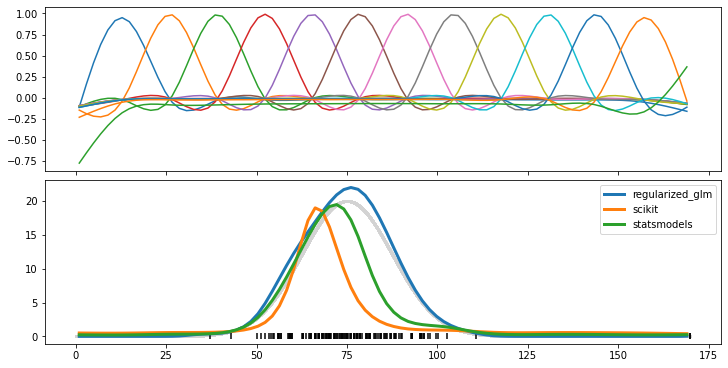

In [69]:
from replay_identification.spiking_likelihood import (make_spline_predict_matrix,
                                                      make_spline_design_matrix, get_firing_rate)
from sklearn.linear_model import PoissonRegressor
import statsmodels.formula.api as smf
import statsmodels.api as sm

spike_ind = 3
place_bin_edges = r.place_bin_edges_
place_bin_centers = r.place_bin_centers_
position = linear_distance[:, np.newaxis]
knot_spacing = 12.5
penalty = 1E-3
is_training = np.ones_like(position)
is_training[(linear_distance > 75) & (linear_distance < 100)] = 0.1
sampling_frequency = 1500
other_alpha = 1E-5


design_matrix = make_spline_design_matrix(
    position, place_bin_edges, knot_spacing)

result = fit_glm(
    spikes[:, spike_ind],
    design_matrix,
    is_training,
    penalty)
place_field_coefficients = result.coefficients
predict_matrix = make_spline_predict_matrix(
    design_matrix.design_info, place_bin_centers)
place_conditional_intensity = get_firing_rate(
    predict_matrix, place_field_coefficients, sampling_frequency=sampling_frequency)


fig, axes = plt.subplots(2, 1, sharex=True, constrained_layout=True,
                         figsize=(10, 5))
axes[0].plot(place_bin_centers, predict_matrix[:, 1:])

axes[1].scatter(linear_distance, place_fields[spike_ind], color='lightgrey', s=1)
axes[1].scatter(position[spikes[:, spike_ind].astype(bool)],
            np.zeros_like(position[spikes[:, spike_ind].astype(bool)]),
            marker='|', color='black'
           )
axes[1].plot(place_bin_centers, place_conditional_intensity, linewidth=3, label='regularized_glm')


clf = PoissonRegressor(alpha=other_alpha, fit_intercept=False, max_iter=25)
clf.fit(design_matrix,
        spikes[:, spike_ind],
        sample_weight=is_training.squeeze(),
       )
place_conditional_intensity = clf.predict(predict_matrix) * sampling_frequency
axes[1].plot(place_bin_centers, place_conditional_intensity, linewidth=3, label='scikit')


glm = sm.GLM(spikes[:, spike_ind], design_matrix, family=families.Poisson(), var_weights=is_training.squeeze())
a = np.ones((design_matrix.shape[1], )) * other_alpha
a[0] = 0.0
glm_result = glm.fit_regularized(alpha=a, L1_wt=0)
place_conditional_intensity = glm_result.predict(predict_matrix) * sampling_frequency
axes[1].plot(place_bin_centers, place_conditional_intensity, linewidth=3, label='statsmodels')
plt.legend()


In [72]:
glm_result.params

array([-8.09672379, -0.64422088, -0.29945819,  0.08442563,  2.19826093,
        3.59843336,  3.4928151 ,  1.66421347,  1.04787057, -0.33013359,
       -0.40586338, -0.43572217, -0.57952436, -0.13098836])

In [71]:
glm.fit_regularized?

Signature:
glm.fit_regularized(
    method='elastic_net',
    alpha=0.0,
    start_params=None,
    refit=False,
    opt_method='bfgs',
    **kwargs,
)
Docstring:
Return a regularized fit to a linear regression model.

Parameters
----------
method : {'elastic_net'}
    Only the `elastic_net` approach is currently implemented.
alpha : scalar or array_like
    The penalty weight.  If a scalar, the same penalty weight
    applies to all variables in the model.  If a vector, it
    must have the same length as `params`, and contains a
    penalty weight for each coefficient.
start_params : array_like
    Starting values for `params`.
refit : bool
    If True, the model is refit using only the variables that
    have non-zero coefficients in the regularized fit.  The
    refitted model is not regularized.
opt_method : string
    The method used for numerical optimization.
**kwargs
    Additional keyword arguments used when fitting the model.

Returns
-------
GLMResults
    An array or a GLM

In [70]:
sm.GLM

Init signature:
sm.GLM(
    endog,
    exog,
    family=None,
    offset=None,
    exposure=None,
    freq_weights=None,
    var_weights=None,
    missing='none',
    **kwargs,
)
Docstring:     
Generalized Linear Models

GLM inherits from statsmodels.base.model.LikelihoodModel

Parameters
----------
endog : array_like
    1d array of endogenous response variable.  This array can be 1d or 2d.
    Binomial family models accept a 2d array with two columns. If
    supplied, each observation is expected to be [success, failure].
exog : array_like
    A nobs x k array where `nobs` is the number of observations and `k`
    is the number of regressors. An intercept is not included by default
    and should be added by the user (models specified using a formula
    include an intercept by default). See `statsmodels.tools.add_constant`.
family : family class instance
    The default is Gaussian.  To specify the binomial distribution
    family = sm.family.Binomial()
    Each family can take a l

In [67]:
PoissonRegressor?

Init signature:
PoissonRegressor(
    *,
    alpha=1.0,
    fit_intercept=True,
    max_iter=100,
    tol=0.0001,
    warm_start=False,
    verbose=0,
)
Docstring:     
Generalized Linear Model with a Poisson distribution.

This regressor uses the 'log' link function.

Read more in the :ref:`User Guide <Generalized_linear_regression>`.

.. versionadded:: 0.23

Parameters
----------
alpha : float, default=1
    Constant that multiplies the penalty term and thus determines the
    regularization strength. ``alpha = 0`` is equivalent to unpenalized
    GLMs. In this case, the design matrix `X` must have full column rank
    (no collinearities).

fit_intercept : bool, default=True
    Specifies if a constant (a.k.a. bias or intercept) should be
    added to the linear predictor (X @ coef + intercept).

max_iter : int, default=100
    The maximal number of iterations for the solver.

tol : float, default=1e-4
    Stopping criterion. For the lbfgs solver,
    the iteration will stop when ``m

In [35]:
glm.fit_regularized?

Signature:
glm.fit_regularized(
    method='elastic_net',
    alpha=0.0,
    start_params=None,
    refit=False,
    opt_method='bfgs',
    **kwargs,
)
Docstring:
Return a regularized fit to a linear regression model.

Parameters
----------
method : {'elastic_net'}
    Only the `elastic_net` approach is currently implemented.
alpha : scalar or array_like
    The penalty weight.  If a scalar, the same penalty weight
    applies to all variables in the model.  If a vector, it
    must have the same length as `params`, and contains a
    penalty weight for each coefficient.
start_params : array_like
    Starting values for `params`.
refit : bool
    If True, the model is refit using only the variables that
    have non-zero coefficients in the regularized fit.  The
    refitted model is not regularized.
opt_method : string
    The method used for numerical optimization.
**kwargs
    Additional keyword arguments used when fitting the model.

Returns
-------
GLMResults
    An array or a GLM